# NoMAD Tutorial

## The Problem
A key challenge limiting the clinical deployment of iBCIs is their robustness to neuronal recording instabilities that cause changes in the particular neurons being monitored over time. As the particular neuronal population being monitored changes, so does the relationship between recorded neural signals and intention, which creates a non-stationary input to the iBCI’s decoder. Without appropriate compensation, iBCI use must be periodically interrupted to perform supervised decoder recalibration, in which neural data are collected while subjects attempt pre-specified movements. This process can be required once or even multiple times per day to maintain high-performance, obstructing activities of daily living and creating additional burdens for iBCI users.

## Description
We begin with a supervised training dataset containing neural activity and corresponding behavior from an initial recording session (Day 0). For a 3-electrode example (electrodes E1, E2, E3), population activity exhibits underlying manifold structure in a 3-D neural state space in which each axis corresponds to the firing rate from a given electrode. The evolution of population activity in time exhibits consistent dynamics (vector field). The relationship between manifold activity and behavior, for simple linear decoding of a hypothetical 1-D behavioral variable, is represented by a Decoding axis, which is assumed to be consistent over time. In a subsequent recording session (Day K), instabilities lead to changes in the recorded neural population, and the Day K activity (E1’, E2’, E3’) has a different relationship to the underlying manifold, dynamics, and decoding axis (schematized by a rotation). With NoMAD [1], our goal is to learn a mapping from the Day K neural activity to the original manifold and dynamics in an unsupervised manner. This allows the original decoding axis to be applied to accurately decode behavior.

![](figures/figure1.png)

## Model
(a) We first train an LFADS model on a given reference Day 0 to estimate the manifold and dynamics from recorded spiking activity. LFADS models neural population dynamics using a series of interconnected recurrent neural networks (RNNs). All of the model parameters are trained by simultaneously minimizing the reconstruction losses of the spiking activity (Poisson negative log-likelihood) and the recorded behavior (mean squared error). (b) To apply the same LFADS model on a later Day K, we freeze the parameters of the trained LFADS model, and introduce a feedforward “Alignment network” to transform the new day’s spiking activity to be compatible with the previously trained LFADS model. The Alignment network is trained by simultaneously minimizing the KL divergence between the distributions of the Day 0 and Day K Generator states and the reconstruction loss of the spiking activity (Poisson NLL).

![](figures/figure2.png)

## Dataset
We will demonstrate NoMAD on data from a monkey performing an isometric force task over 95 days. On each trial, the monkey's goal is to exert force in two dimensions to control a cursor to reach one of eight targets. This dataset has been previously released on Dryad [2].

For convenient use in our tutorial, we have provided this Day 0 and Day 95 from this dataset processed in two different ways: 
- Chopped: To train LFADS and NoMAD, we use the continuous data chopped into 600ms segments with 120ms of overlap. More information on the details of this procedure can be found in [1, 3].    
- Trialized: To evaluate decoding, we use only successful trials and isolate a window of neural and behavioral data that is 250ms before and 500ms after movement onset (see Methods of [1] for details). This helps to ensure that the decoding performance is representative of the windows of behavior that we care about.

In both cases, data is processed into 20ms bins.

1. > Karpowicz BM, Ali YH, Wimalasena LN, Sedler AR, Keshtkaran MR, Bodkin K, Ma X, Rubin DB, Williams ZM, Cash SS, Hochberg LR, Miller LE, Pandarinath C. Stabilizing brain-computer interfaces through alignment of latent dynamics. bioRxiv preprint. doi:10.1101/2022.04.06.487388. 2022 Nov 08.
2. >  Ma X, Rizzoglio F, Thacker S, Ethier C, Perich M, Miller L. Data from: Using adversarial networks to extend brain computer interface decoding accuracy over time. Dryad entry. doi:10.5061/dryad.cvdncjt7n. 2023 Sep 29.
3. > Keshtkaran MR*, Sedler AR*, Chowdhury RH, Tandon R, Basrai D, Nguyen SL, Sohn H, Jazayeri M, Miller LE, Pandarinath C. A large-scale neural network training framework for generalized estimation of single-trial population dynamics. Nature Methods. doi:10.1038/s41592-022-01675-0. 2022 Nov 28.

### Load the necessary packages

In [7]:
import shutil, json, sys, os, pickle, h5py, scipy
from os import path, chmod
import numpy as np
import pandas as pd 
from yacs.config import CfgNode as CN

import matplotlib.pyplot as plt
%matplotlib inline

from lfads_tf2.subclasses.behavior.models import BehaviorLFADS
from lfads_tf2.tuples import LoadableData, LFADSInput
from lfads_tf2.utils import load_posterior_averages, restrict_gpu_usage, unflatten
restrict_gpu_usage(0)

from nomad.models import AlignLFADS
from nomad.tuples import AlignInput, SingleModelOutput, AlignmentOutput
from nomad.defaults import get_cfg_defaults

import tensorflow as tf
tf.config.experimental_run_functions_eagerly(
    True
)

from utils import get_causal_model_output, generate_lagged_matrix, fit_and_eval_decoder

### Train the Day 0 LFADS Model

In [2]:
# train the LFADS Day 0 model
if os.path.exists('day0_model/lfads_ckpts/'):
    model = BehaviorLFADS(model_dir='day0_model')
else:
    model = BehaviorLFADS(cfg_path='configs/lfads.yaml')
    model.train()

Loading model from day0_model.
This `lfads_tf2` may not match the one used to create the model.
Loading datasets with prefix lfads from chopped_data/day0/
Restoring the most recent model.


### Train and Evaluate Day 0 Decoder

We will perform inference using the trialized data to get the Day 0 LFADS generator states. We then train a Wiener Filter decoder on this neural representation to predict the monkey's force on Day 0 with high accuracy.

In [3]:
# load trialized data 
with open('trialized_data/day0_trials.pkl', 'rb') as f:
    day0_trials= pickle.load(f)
spikes = day0_trials['spikes']
stack_spikes = np.dstack(spikes)

# get causal LFADS Day 0 outputs (trialized)
day0_gen_states = np.dstack([get_causal_model_output(model, 
                            0.02, 
                            stack_spikes[:,:,tr], 
                            ['gen_states'], 
                            {
                                'gen_states': model.cfg.MODEL.GEN_DIM
                            })['gen_states'] for tr in range(stack_spikes.shape[2])])

In [4]:
# train decoder 
behavior = np.concatenate(day0_trials['force'], axis=-1).T
keep_trials = np.isnan(behavior).sum(axis=(1,2)) == 0
behavior = behavior[keep_trials, :, :]
day0_gen_states = day0_gen_states.T[keep_trials, :, :]
ntrials, ndim, ntime = behavior.shape

n_train_trials = int(0.8 * ntrials)
n_test_trials = ntrials - n_train_trials
train_trials = np.random.choice(ntrials, n_train_trials, replace=False)
test_trials = np.setdiff1d(np.arange(ntrials), train_trials)

train_behavior = behavior[train_trials, :, :]
test_behavior = behavior[test_trials, :, :]
train_gen_states = day0_gen_states[train_trials, :, :]
test_gen_states = day0_gen_states[test_trials, :, :]

decode_train_behavior = np.reshape(np.swapaxes(train_behavior, 0, 1), (ndim, n_train_trials * ntime)).T
decode_test_behavior = np.reshape(np.swapaxes(test_behavior, 0, 1), (ndim, n_test_trials * ntime)).T
decode_train_neural = np.reshape(np.swapaxes(train_gen_states, 0, 1), (model.cfg.MODEL.GEN_DIM, n_train_trials * ntime)).T
decode_test_neural = np.reshape(np.swapaxes(test_gen_states, 0, 1), (model.cfg.MODEL.GEN_DIM, n_test_trials * ntime)).T

lagged_train_gen_states = generate_lagged_matrix(decode_train_neural, 3)
lagged_test_gen_states = generate_lagged_matrix(decode_test_neural, 3)
score, decoder, pred_force = fit_and_eval_decoder(
    lagged_train_gen_states,
    decode_train_behavior[3:, :],
    lagged_test_gen_states,
    decode_test_behavior[3:, :],
    return_preds=True
    )
print(score)

/home/bkarpo2/miniconda3/envs/natcomms/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/bkarpo2/miniconda3/envs/natcomms/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in s

/home/bkarpo2/miniconda3/envs/natcomms/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/bkarpo2/miniconda3/envs/natcomms/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in s

0.9582330618360424


/home/bkarpo2/miniconda3/envs/natcomms/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Text(-700, 550, 'Force $R^2$ = 0.96')

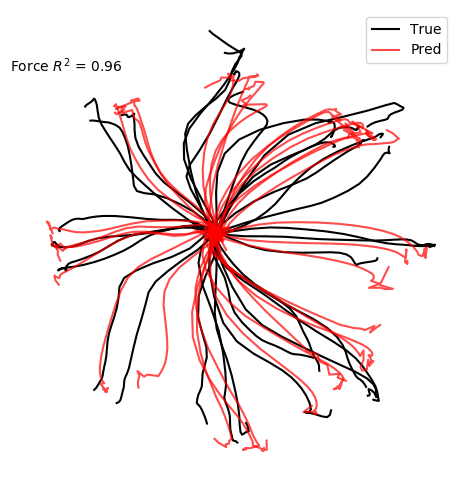

In [8]:
# plot decoder outputs 
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_aspect('equal')
true_behavior = np.split(decode_test_behavior, n_test_trials, axis=0)
true_plots = [plt.plot(tr[:, 0], tr[:, 1], label='True', color='k') for tr in true_behavior]
predicted_behavior = np.split(np.pad(pred_force, ((3,0), (0,0)), constant_values=np.nan), n_test_trials, axis=0)
pred_plots = [plt.plot(tr[:, 0], tr[:, 1], label='Pred', color='r', alpha=0.7) for tr in predicted_behavior]
# make axes invisible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.legend([true_plots[0][0], pred_plots[0][0]], ['True', 'Pred'])
plt.text(-700, 550, 'Force $R^2$ = {:.2f}'.format(score))


### Evaluate Decoder on Day 95

To confirm that the Day 0 LFADS model and decoder do not work well on Day 95, we will get the generator states on Day 95 from the Day 0 model. Then, we will try to use the Day 0 fixed decoder to predict the force on Day 95. We find that there is a significant drop in prediction accuracy due to neural nonstationarities.

In [9]:
# if we pass Day K data through the model 
with open('trialized_data/dayk_trials.pkl', 'rb') as f:
    dayk_trials= pickle.load(f)
spikes = dayk_trials['spikes']
stack_spikes = np.dstack(spikes)

# get causal LFADS Day K outputs (trialized)
dayk_gen_states = np.dstack([get_causal_model_output(model, 
                            0.02, 
                            stack_spikes[:,:,tr], 
                            ['gen_states'], 
                            {
                                'gen_states': model.cfg.MODEL.GEN_DIM
                            })['gen_states'] for tr in range(stack_spikes.shape[2])])

In [10]:
# the decoder does not generalize well to Day K data
dayk_behavior = np.concatenate(dayk_trials['force'], axis=-1).T
keep_trials = np.isnan(dayk_behavior).sum(axis=(1,2)) == 0
valid_dayk_behavior = dayk_behavior[keep_trials, :, :]
valid_dayk_gen_states = dayk_gen_states.T[keep_trials, :, :]
ntime, ndims, ntrials = valid_dayk_gen_states.shape

decode_gen_states = np.reshape(np.swapaxes(valid_dayk_gen_states, 0, 1), (model.cfg.MODEL.GEN_DIM, ntrials * ntime)).T
lagged_decode_gen_states = generate_lagged_matrix(decode_gen_states, 3)
decode_behavior = np.reshape(np.swapaxes(valid_dayk_behavior, 0, 1), (2, ntrials * ntime)).T

score = decoder.score(lagged_decode_gen_states, decode_behavior[3:, :])
dayk_pred_force = decoder.predict(lagged_decode_gen_states)
print(score)

0.5033448524131714


/home/bkarpo2/miniconda3/envs/natcomms/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


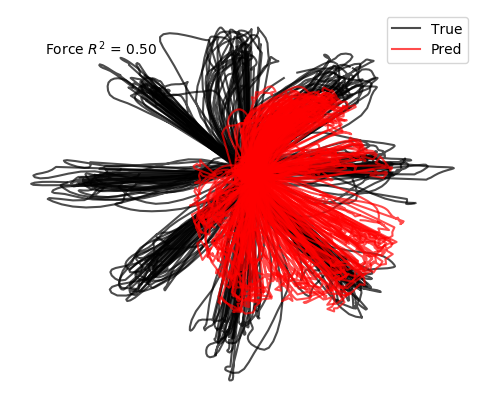

In [11]:
# plot decoder outputs 
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_aspect('equal')
true_behavior = np.split(decode_behavior, ntrials, axis=0)
true_plots = [plt.plot(tr[:, 0], tr[:, 1], label='True', color='k', alpha=0.7) for tr in true_behavior]
predicted_behavior = np.split(np.pad(dayk_pred_force, ((3,0), (0,0)), constant_values=np.nan), ntrials, axis=0)
pred_plots = [plt.plot(tr[:, 0], tr[:, 1], label='Pred', color='r', alpha=0.7) for tr in predicted_behavior]
# make axes invisible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.legend([true_plots[0][0], pred_plots[0][0]], ['True', 'Pred'])
plt.text(-950, 550, 'Force $R^2$ = {:.2f}'.format(score))
plt.show()

### Train NoMAD Alignment 

In an attempt to restore decoding performance, we will use the Day 95 neural data to train the NoMAD model. This should result in a manifold on Day 95 that is more similar to that which we learned on Day 0, thereby allowing the Day 0 decoder to work on Day 95 with high accuracy. 

In [ ]:
# initialize nomad model
if not os.path.exists('align_model/align_ckpts/'):
    align_cfg = get_cfg_defaults()
    cfg_update_path = 'configs/nomad.yaml'
    align_cfg.merge_from_file(cfg_update_path)
    align_model = AlignLFADS(cfg_node=align_cfg)
else:
    align_model = AlignLFADS(align_dir='align_model/')

# load the h5 files into the model
day0_datadict = h5py.File('chopped_data/day0/lfads_Jango_20150730_001.h5', 'r')
dayk_datadict = h5py.File('chopped_data/day95/lfads_Jango_20151102_001.h5', 'r')

Initializing new aligner
Overwriting align directory
Loading model from align_model/pbt_model.
This `lfads_tf2` may not match the one used to create the model.
Loading datasets with prefix lfads from chopped_data/day0/
Restoring the most recent model.
Loading model from align_model/pbt_model.
This `lfads_tf2` may not match the one used to create the model.
Loading datasets with prefix lfads from chopped_data/day0/
Restoring the most recent model.


In [13]:
align_input = AlignInput(
    day0_train_data=day0_datadict['train_data'],
    day0_valid_data=day0_datadict['valid_data'],
    dayk_train_data=dayk_datadict['train_data'],
    dayk_valid_data=dayk_datadict['valid_data'],
    day0_train_inds=day0_datadict['train_inds'],
    day0_valid_inds=day0_datadict['valid_inds'],
    dayk_train_inds=dayk_datadict['train_inds'],
    dayk_valid_inds=dayk_datadict['valid_inds'])
align_model.load_datasets(align_input)
# move the day 95 norm parameters to appropriate location
shutil.copy('chopped_data/day95/normalization.h5', 'align_model/normalization_dayk.h5')
align_model.smart_init() # loads the normalization matrix in

Using datasets passed as arguments to `load_datasets`.
Setting Day K normalization parameters...


In [14]:
if not os.path.exists('align_model/align_ckpts/'):
    done = False
    while not done:
        results = align_model.train_epoch()
        done = results.get('done', False)

Epoch 1/9999, Patience: 0, LR: 4.00E-04


4/4 [==============================] - 17s 4s/step
    loss: 16.007 -     kl: 15.863 -     nll: 0.365 - gnorm: 1187974.125 - kl_gnorm: 118.798 - nll_gnorm: 0.033
val_loss: 11.252 - val_kl: 11.216 - val_nll: 0.359
Epoch 2/9999, Patience: 0, LR: 4.00E-04
4/4 [==============================] - 20s 5s/step
    loss: 9.244 -     kl: 9.067 -     nll: 0.355 - gnorm: 447614.031 - kl_gnorm: 44.764 - nll_gnorm: 0.058
val_loss: 8.232 - val_kl: 8.163 - val_nll: 0.349
Epoch 3/9999, Patience: 0, LR: 4.00E-04
4/4 [==============================] - 20s 5s/step
    loss: 8.431 -     kl: 8.222 -     nll: 0.345 - gnorm: 350228.625 - kl_gnorm: 35.023 - nll_gnorm: 0.078
val_loss: 8.011 - val_kl: 7.910 - val_nll: 0.340
Epoch 4/9999, Patience: 0, LR: 4.00E-04
4/4 [==============================] - 24s 6s/step
    loss: 8.418 -     kl: 8.178 -     nll: 0.337 - gnorm: 368460.875 - kl_gnorm: 36.843 - nll_gnorm: 0.094
val_loss: 7.764 - val_kl: 7.633 - val_nll: 0.332
Epoch 5/9999, Patience: 0, LR: 4.00E-04
4/4 [=

In [15]:
# get NoMAD outputs 
with open('trialized_data/dayk_trials.pkl', 'rb') as f:
    dayk_trials= pickle.load(f)
spikes = dayk_trials['spikes']
stack_spikes = np.dstack(spikes)

# get causal LFADS Day K outputs (trialized)
align_gen_states = np.dstack([get_causal_model_output(align_model.lfads_dayk, 
                            0.02, 
                            stack_spikes[:,:,tr], 
                            ['gen_states'], 
                            {
                                'gen_states': model.cfg.MODEL.GEN_DIM
                            })['gen_states'] for tr in range(stack_spikes.shape[2])])

/home/bkarpo2/miniconda3/envs/natcomms/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.8656602431998893


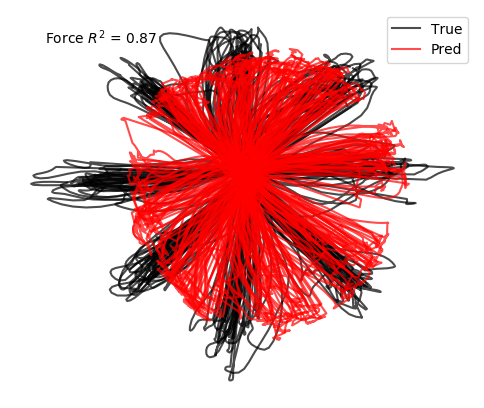

In [16]:
# show decoder now generalizes
dayk_behavior = np.concatenate(dayk_trials['force'], axis=-1).T
keep_trials = np.isnan(dayk_behavior).sum(axis=(1,2)) == 0
valid_dayk_behavior = dayk_behavior[keep_trials, :, :]
valid_align_gen_states = align_gen_states.T[keep_trials, :, :]
ntime, ndims, ntrials = valid_align_gen_states.shape

decode_gen_states = np.reshape(np.swapaxes(valid_align_gen_states, 0, 1), (model.cfg.MODEL.GEN_DIM, ntrials * ntime)).T
lagged_decode_gen_states = generate_lagged_matrix(decode_gen_states, 3)
decode_behavior = np.reshape(np.swapaxes(valid_dayk_behavior, 0, 1), (2, ntrials * ntime)).T

score = decoder.score(lagged_decode_gen_states, decode_behavior[3:, :])
dayk_pred_force = decoder.predict(lagged_decode_gen_states)
print(score)
# plot decoder outputs
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_aspect('equal')
true_behavior = np.split(decode_behavior, ntrials, axis=0)
true_plots = [plt.plot(tr[:, 0], tr[:, 1], label='True', color='k', alpha=0.7) for tr in true_behavior]
predicted_behavior = np.split(np.pad(dayk_pred_force, ((3,0), (0,0)), constant_values=np.nan), ntrials, axis=0)
pred_plots = [plt.plot(tr[:, 0], tr[:, 1], label='Pred', color='r', alpha=0.7) for tr in predicted_behavior]
# make axes invisible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.legend([true_plots[0][0], pred_plots[0][0]], ['True', 'Pred'])
plt.text(-950, 600, 'Force $R^2$ = {:.2f}'.format(score))
plt.show()